## Titanic Problem w Ensembles

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from collections import Counter
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier,VotingClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

### Import Data

In [3]:
train = pd.read_csv('dataset/titanic/train.csv')
test = pd.read_csv('dataset/titanic/test.csv')

In [4]:
idtest = test['PassengerId']

### Outlier detection : https://www.youtube.com/watch?v=9aDHbRb4Bf8&t=10s

In [5]:
def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over dataframe
    for col in features:

        # Find 1st Quartile
        Q1 = np.percentile(df[col],25)

        # Find 3rd Quartile
        Q3 = np.percentile(df[col],75)

        # Find InterQuartile Range
        IQR = Q3 - Q1

        # Setting outlier step to 1.5
        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # appending indices
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    
    multiple_outliers = list(k for k,v in outlier_indices.items() if v>n)

    return multiple_outliers

outliers_to_drop = detect_outliers(train,2,['Age','SibSp','Parch','Fare'])

In [6]:
outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

### Counter Object

In [7]:
z=['blue','green','red','green','red','green','blue']
cntZ = Counter(z)

cntZ

Counter({'blue': 2, 'green': 3, 'red': 2})

In [8]:
list(k for k,v in cntZ.items() if v>2)

['green']

In [9]:
train.loc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


#### If we see outliers are having either high fare or high SibSp value

In [10]:
train = train.drop(outliers_to_drop,axis=0).reset_index(drop=True)

In [11]:
train.shape

(881, 12)

### Feature Engineering

In [12]:
train_len = len(train)

df = pd.concat(objs=[train,test],axis=0).reset_index(drop=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 12 columns):
Age            1043 non-null float64
Cabin          292 non-null object
Embarked       1297 non-null object
Fare           1298 non-null float64
Name           1299 non-null object
Parch          1299 non-null int64
PassengerId    1299 non-null int64
Pclass         1299 non-null int64
Sex            1299 non-null object
SibSp          1299 non-null int64
Survived       881 non-null float64
Ticket         1299 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 121.9+ KB


#### Check for missing values

In [14]:
df.fillna(np.nan, inplace=True)

df.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

#### Feature Analysis

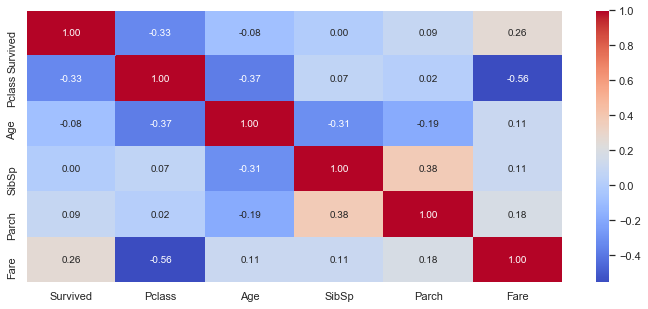

In [15]:
plt.figure(figsize=(12,5))

sns.heatmap(train[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].corr(),
           annot=True,
           cmap='coolwarm',
           fmt='.2f');

1. Fare is having correlation w Pclass and Survived


2. Pclass is having correlation w Fare and Survived and Age


3. SibSp and Parch are highly correlated

### Exploring SibSp

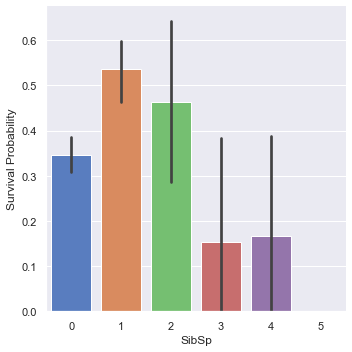

In [16]:
g = sns.factorplot(x='SibSp',y='Survived',data=train,kind='bar',palette='muted')
g = g.set_ylabels('Survival Probability')

1. More SibSp less survival


2. Single passengers and SibSp = 1,2 survived more than SibSp > 2

#### Parch

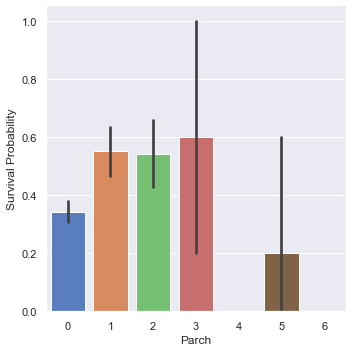

In [17]:
g = sns.factorplot(x='Parch',y='Survived',data=train,kind='bar',palette='muted')
g = g.set_ylabels('Survival Probability')

1. Smaller families have higher chance of survival.


* Single (0)

* Small (1,2)

* Medium (3,4)

* Large (5,6)

#### Age

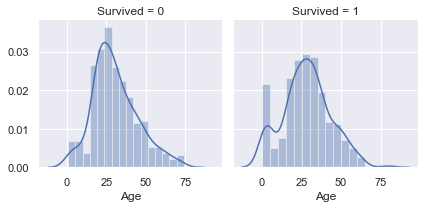

In [18]:
g = sns.FacetGrid(train,col='Survived')

g = g.map(sns.distplot,'Age')

1. Age distribution is of gaussian nature


2. Peak is indicating that younger population survived much more than older population.

#### Fare

In [19]:
df['Fare'].isnull().sum()

1

In [20]:
df['Fare'].fillna(df['Fare'].median(),inplace=True)

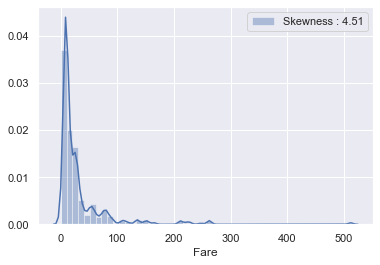

In [21]:
# Exploring fare distribution

g = sns.distplot(df['Fare'],label='Skewness : %.2f'%(df['Fare'].skew()))

g = g.legend()

##### Let's do a log transformation to reduce the skew

In [22]:
df['Fare'] = df['Fare'].map(lambda x: np.log(x) if x>0 else 0)

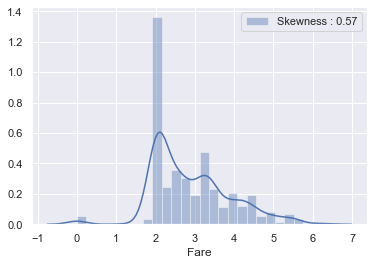

In [23]:
# Exploring fare distribution

g = sns.distplot(df['Fare'],label='Skewness : %.2f'%(df['Fare'].skew()))

g = g.legend()

##### Let's take a look at the categorical columns

#### Sex

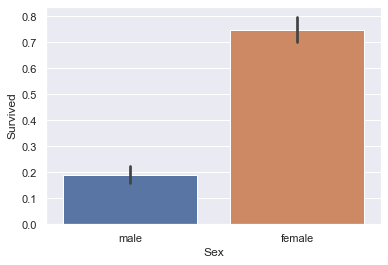

In [24]:
g = sns.barplot(x='Sex',y='Survived',data=train)

In [25]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


#### PClass

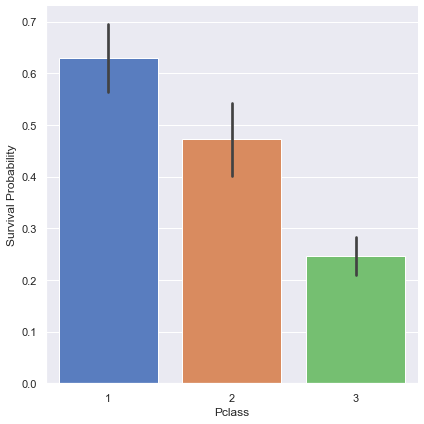

In [26]:
g = sns.factorplot(x='Pclass',y='Survived',data=train,kind='bar',palette='muted',size=6)

g = g.set_ylabels('Survival Probability')

Survival Prob (PClass=1) > Survival Prob (PClass=2) > Survival Prob (PClass=3)

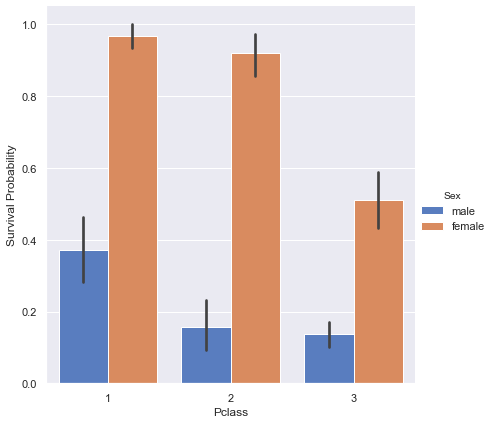

In [27]:
g = sns.factorplot(x='Pclass',y='Survived',data=train,kind='bar',palette='muted',size=6,hue='Sex')

g = g.set_ylabels('Survival Probability')

Trend by Sex ratio remains same.

#### Embarked

In [28]:
df['Embarked'].isnull().sum()

2

In [29]:
df['Embarked'].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

S = Southampton


C = Cherbourg


Q = Queenstown

In [30]:
df['Embarked'].fillna('S',inplace=True)

In [31]:
df['Embarked'].isnull().sum()

0

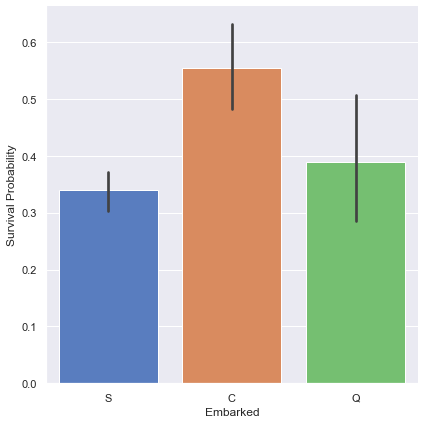

In [32]:
g = sns.factorplot(x = 'Embarked',
                   y = 'Survived',
                   data = train,
                   kind = 'bar',
                   size = 6,
                   palette = 'muted')

g = g.set_ylabels('Survival Probability')

1. Highest survival of passengers who embarked from C 

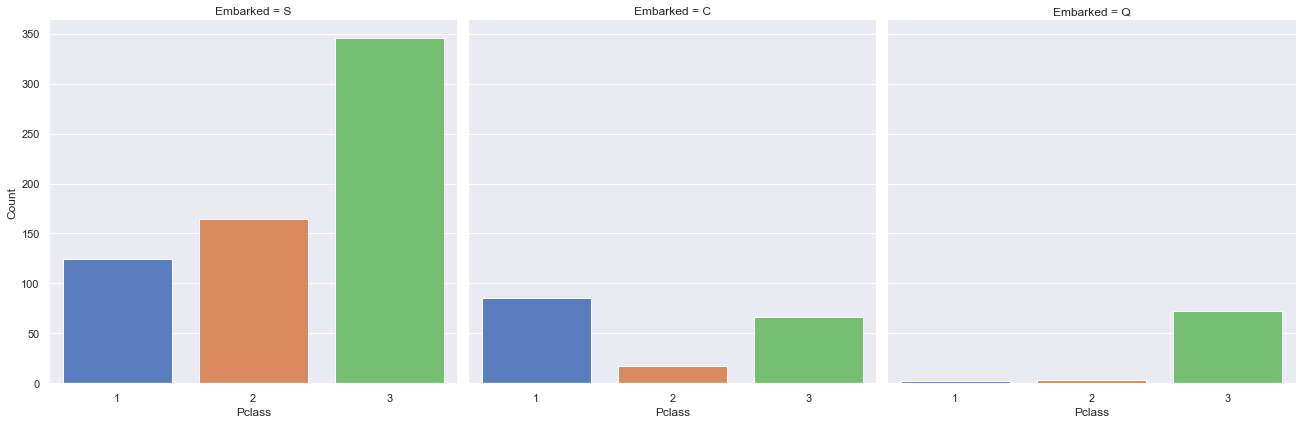

In [36]:
g = sns.factorplot(x = 'Pclass',
                   col = 'Embarked',
                   data = train,
                   kind = 'count',
                   size = 6,
                   palettex = 'muted')

g = g.set_ylabels('Count')

#### Missing value imputations

In [38]:
df.isnull().sum()

Age             256
Cabin          1007
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

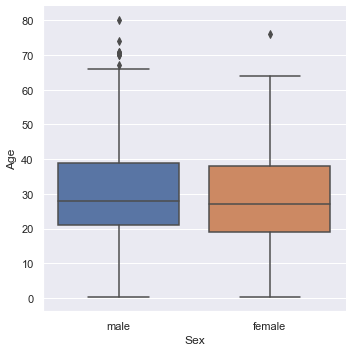

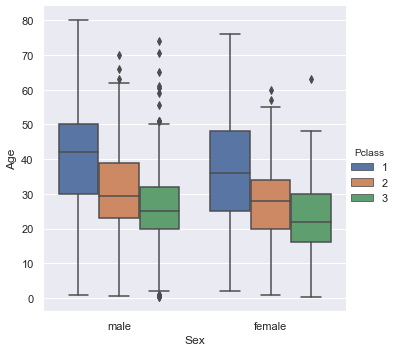

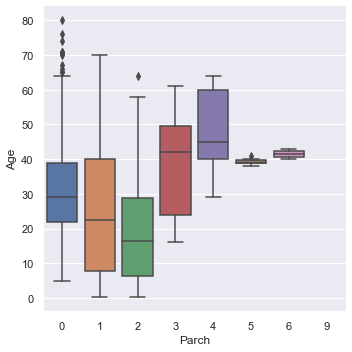

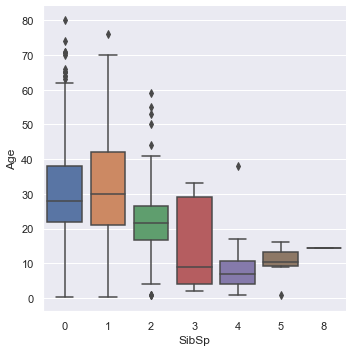

In [40]:
g = sns.factorplot(y='Age',x='Sex',data=df,kind='box')
g = sns.factorplot(y='Age',x='Sex',hue='Pclass',data=df,kind='box')
g = sns.factorplot(y='Age',x='Parch',data=df,kind='box')
g = sns.factorplot(y='Age',x='SibSp',data=df,kind='box')